In [1]:
%load_ext autoreload
%autoreload 2
#import plum
#plum.autoreload.activate()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json

from functools import partial, reduce

In [3]:
# Added to silence some warnings.
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

import flax
import optax

/opt/anaconda3/envs/q_embedding_new/lib/python3.8/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [4]:
import pennylane as qml
import netket as nk
from netket.operator.spin import sigmax,sigmaz

In [5]:
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=250)

In [6]:
from utils                  import *
from hamiltonians           import *
from quantum_circuits       import *
from classic_models         import *
from truncated_spin         import Spin

## Ammonia - System and Hamiltonian

In [7]:
phys_qubits       = 4
n_classical_spins = 2

ancilla_qubits    = 1
tot_qubits        = phys_qubits + ancilla_qubits

q_index           = [0,1,2,3]
c_index           = [4,5]#,6,7,8,9,10,11]#,12,13]
tot_spins         = n_classical_spins + phys_qubits
tot_elec_classic  = 2 #number of electrons in the classical part
tot_elec_quantum  = 2 #number of electrons in the quantum part (always 2 in the HONO/LUNO active space)
tot_elec          = tot_elec_classic+tot_elec_quantum

In [8]:
device_phys         = qml.device("default.qubit", wires=list(range(phys_qubits)))
device_with_ancilla = qml.device("default.qubit", wires=list(range(phys_qubits))+["a"])

# Define the Hilbert space by specifying the maximum and minimum amount of electrons with spin up and down

max_up = tot_elec//2
if max_up >  n_classical_spins//2:
    max_up = n_classical_spins//2

min_up = tot_elec//2-phys_qubits//2

print("Max up:",max_up,"min up:", min_up)
# Particle preserving hilbert space
valid_samples = True # If True, the samples are generated with the correct number of particles
hi = Spin(N=n_classical_spins//2, maximum_up=max_up,minimum_up=min_up) * Spin(N=n_classical_spins//2, maximum_up=max_up,minimum_up=min_up)

Max up: 1 min up: 0


In [9]:
## Prepare the Hamiltonian

m_name     = "NH3"
orbit_list = [0,1,2,6,7]
orbit_str  = "".join([str(orb) for orb in orbit_list])
distance   = 1.5

mol_file = "./../data/ammonia/NH3_qubit_op/NH3_"+orbit_str+"reduced/"+m_name+"_qubit_op_"+str(tot_spins)+"qubits_"+str(distance)+"r_"+orbit_str+"reduced"+"_aug-cc-pvqz_iao.dat"

In [10]:
h_mixed = mixed_hami_from_file(mol_file, hi, tot_spins, q_index, c_index)

Number of pure  quantum op: 27
Number of pure  classic op: 3
Number of       mixed   op: 88
Number of quantum    group: 72


#### Energy of the GS 

In [11]:
#hi_tot    = Spin(N=tot_spins//2,maximum_up=tot_elec//2, minimum_up=tot_elec//2)*Spin(N=tot_spins//2,maximum_up=tot_elec//2, minimum_up=tot_elec//2)
#hi_tot_non_truncated    = nk.hilbert.Spin(s=1/2,N=tot_spins) # Non-truncated hilbert space
hi_tot    = Spin(N=tot_spins,maximum_up=tot_elec, minimum_up=tot_elec)

In [12]:
## Total Hamiltonian
htot_nk = netket_hami_from_file(mol_file, hi_tot, tot_spins)

In [13]:
## Ground state energy
E_gs, psi_gs = nk.exact.lanczos_ed(htot_nk, compute_eigenvectors=True)

In [14]:
E_gs[0]

-56.1676555058106

## Circuit

In [15]:
## Total circuit

depth   =  1
my_circ = (circ_pass, molecule_jw_init_singles, circ_chemistry_double)

In [16]:
## Print the circuit
draw_device = qml.device("default.qubit", list(range(phys_qubits))+["a"])

In [17]:
@qml.qnode(draw_device)
def draw_circuit(params,θ_σ,θ_η):
    
    my_circ[1](draw_device, params, θ_σ, θ_η)
    my_circ[2](draw_device,  params)
    
        
    return qml.expval(qml.PauliZ(1))
    #return qml.state()

In [26]:
drawer = qml.draw(draw_circuit)
print(drawer(jnp.asarray(list(range(1,2))),jnp.asarray([1,1]+list(range(2))),None))

0: ──CX(0.00)──||─╭G(0.00)──||─╭G²(1.00)──||─┤     
1: ──CX(1.00)──||─╰G(0.00)──||─├G²(1.00)──||─┤  <Z>
2: ──CX(0.00)──||─╭G(1.00)──||─├G²(1.00)──||─┤     
3: ──CX(1.00)──||─╰G(1.00)──||─╰G²(1.00)──||─┤     


## Final training 

In [19]:
seed    = jax.random.PRNGKey(int(time.time()))

########## Initialise RBM Spin Machine
ma        = nk.models.RBM(alpha=1, param_dtype=float)
ma_lin    = RBM_Linear(alpha=1, param_dtype=float)
# Random initialization
pars_c     = ma.init(jax.random.PRNGKey(int(time.time())), hi.random_state(seed, 1))
pars_c_lin = ma_lin.init(jax.random.PRNGKey(int(time.time())), hi.random_state(seed, 1))

## Initialise the sampler 
#sa       = nk.sampler.MetropolisLocal(hi, n_chains=10) # Metropolis sampling for large systems
sa       = nk.sampler.ExactSampler(hi) # Exact sampling for small systems
sa_state = sa.init_state(ma, pars_c, seed)

In [20]:
########## Sample to angle machine
angles_a = 2  
alpha_a  = 2
sta    = Sample_to_angle_particle_preserving(alpha=alpha_a, angles=angles_a,n_elec=tot_elec_classic+tot_elec_quantum, param_dtype=float)
pars_a = sta.init(jax.random.PRNGKey(int(time.time())), jnp.array([-1 for  i in range(n_classical_spins)]))


########## Quantum circuit
pars_q = np.random.rand(1)

# Put quantum and classical params together
pars_all            = flax.core.unfreeze(pars_c)
pars_all['quantum'] = pars_q
pars_all['angles']  = pars_a
pars_all            = flax.core.freeze(pars_all)

### Optimizer

In [21]:
########### Declare the optimizer
# Mixed with SR
# using SGD if we choose to use SR in the classical parameters
sr       = True
unbiased = False # True if we want to use the unbiased estimator    


if sr:
    opt_classical = optax.sgd(0.01)
else:
    opt_classical = optax.adam(learning_rate=0.01) 

opt_quantum = optax.adam(learning_rate=0.01)#optax.sgd(0.0)#
opt_angles  = optax.adam(learning_rate=0.01) #optax.yogi(learning_rate=0.01)#
optimizer   = optax.multi_transform({'o1': opt_classical, 'o2': opt_quantum,'o3': opt_angles}, flax.core.freeze({"params":"o1", "quantum":"o2", "angles":"o3"}))

opt_state = optimizer.init(pars_all)

## Optimization loop

In [22]:
## Loop info
n_steps    = 1
n_samples  = 1000

In [23]:
## Saving quantities 

## Total energies and errors
e_vec      = []
## Gradient 
grad_vec = []

In [24]:
# Save the best result

e_best     = 10
pars_best  = pars_all
sigma_best = 0
save_step  = 5

for step_c in range(n_steps):
    pars_ac, pars_q = pars_all.pop("quantum")
    pars_c, pars_a  = pars_ac.pop("angles")
    
    # Sample from the classical distribution
    
    sa_state        = sa.reset( ma, pars_c, sa_state)
    sigma, sa_state = sa.sample(ma, pars_c, state=sa_state, chain_length=n_samples)
    
    # Evaluate the energy both on classical and quantum computer
    energy, grad_e = e_tot_and_grad(ma, ma_lin, device_with_ancilla, my_circ, pars_all, sigma, sta, h_mixed,unbiased=unbiased,valid_samples=valid_samples)

    ## =================== SR for the classical gradient ===================
    if sr:

        grad_e_real = jax.tree_map(lambda x : x.real, grad_e)
        grad_e      = compute_SR(ma,sigma,grad_e_real,pars_c,diag_shift=0.001)
    
    #=======================================================================
    
        
    ## Print energy    
    if step_c % 50 == 0:
        
        print(f"Step {step_c}, energy: {energy.mean.real:.8f} +- {energy.error_of_mean:.8f}")
        print("--------------------------------------------------------------")
        
    e_vec.append(energy)
    grad_vec.append(grad_e)
    
    # Save the best results
    if energy.mean < e_best:
        e_best     = energy.mean
        pars_best  = pars_all
        sigma_best = sigma
    
   
    # With optax
    pars_all, opt_state = optimizer_step(optimizer,opt_state, grad_e, pars_all)
    
print(f"Final energy: {energy}")

Step 0, energy: -55.80636010 +- 0.00494194
--------------------------------------------------------------
Final energy: -55.8064-0.0000j ± 0.0049 [σ²=0.0323]


In [56]:
final_variational = e_tot(ma, device_with_ancilla, my_circ, pars_best, sigma_best.reshape(-1, sigma_best.shape[-1]), sta, h_mixed,valid_samples=valid_samples)
final_variational  

-5.617e+01-7.198e-15j ± 0.000e+00 [σ²=0.000e+00]

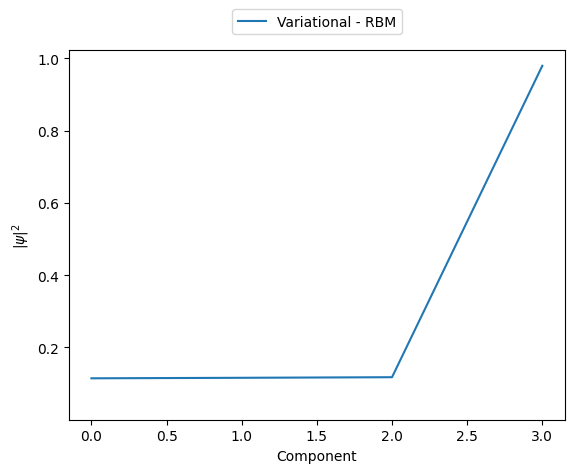

In [57]:
## Plot NN final state 
## Extract params
pars_ac, pars_q = pars_best.pop("quantum")
pars_c, pars_a  = pars_ac.pop("angles")

σ  = hi.all_states()
wfn_c = jnp.exp(ma.apply(pars_c, σ))
wfn_c = wfn_c / jnp.sqrt(jnp.sum(jnp.abs(wfn_c)**2))

#plt.plot(jnp.sqrt(jnp.abs(psi_gs)**2),label="Exact")
plt.plot(jnp.sqrt(jnp.abs(wfn_c)**2),label="Variational - RBM",linestyle="solid")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.13),ncol=2)
plt.xlabel("Component")
plt.ylabel(r"$|\psi|^2$")
plt.ylim(ymin=1e-4)
plt.show()

## Plot data

#### Plot total energy

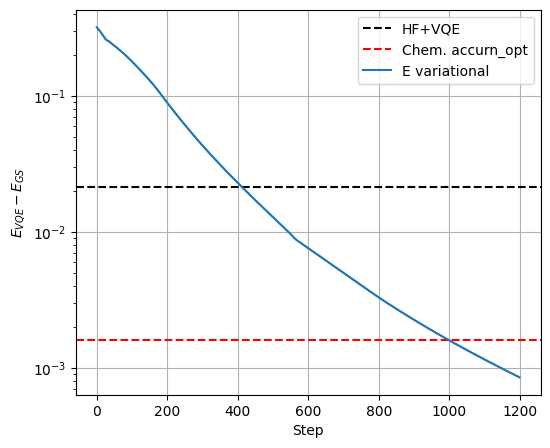

In [58]:
fig, ax = plt.subplots(1,figsize=[6.0,5.0],sharex=True)
e_tot_ref = E_gs#energy_exact["1.5"][orbit_str][0]


mean_e = np.asarray([np.real(energy.mean) for energy in e_vec])
err_e  = np.asarray([np.real(energy.error_of_mean) for energy in e_vec])
var_e  = np.asarray([np.real(energy.variance) for energy in e_vec])

n_opt  = list(range(len(mean_e)))



## Plot energy with error
ax.fill_between(n_opt, mean_e-err_e-e_tot_ref, mean_e+err_e-e_tot_ref, color="C0", alpha=0.5)
ax.errorbar(n_opt,mean_e-e_tot_ref,label="E variational",color="C0")



ax.set_xlabel("Step")
ax.set_ylabel(r"$E_{VQE}-E_{GS}$")
ax.legend()
ax.grid()
ax.set_yscale("log")

fig.subplots_adjust(hspace=0.04)
plt.show()